# Variational Autoencoders for MNIST data augmentation

In [54]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F

from torchvision import datasets, transforms
import torchvision.datasets as dset
import torchvision.transforms as transforms

from torchvision.utils import save_image

from torch.autograd import Variable
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split

import os

In [70]:
use_cuda = torch.cuda.is_available()

root = './data'
if not os.path.exists(root):
    os.mkdir(root)

In [71]:
CUDA = True
SEED = 1
BATCH_SIZE = 128
LOG_INTERVAL = 10
EPOCHS = 50

ZDIMS = 20

## Load MNIST dataset

In [65]:
# DataLoader instances will load tensors directly into GPU memory
data_loader_args = {'num_workers': 4, 'pin_memory': True} if CUDA else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **data_loader_args)

# Same for test data
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **data_loader_args)

In [67]:
for img in train_loader:
    print(img[1])
    
#     plt.imshow(img, cmap='gray')
    break

tensor([1, 9, 9, 6, 8, 5, 5, 2, 2, 1, 4, 1, 0, 1, 2, 2, 2, 4, 0, 6, 8, 0, 7, 0,
        5, 6, 9, 6, 4, 4, 8, 3, 6, 0, 2, 3, 5, 5, 9, 8, 6, 6, 7, 0, 1, 7, 1, 2,
        5, 6, 2, 4, 1, 3, 4, 3, 5, 1, 7, 7, 9, 8, 0, 1, 4, 5, 1, 6, 3, 3, 4, 4,
        9, 9, 4, 7, 0, 8, 6, 5, 4, 2, 1, 7, 5, 3, 1, 1, 7, 4, 5, 0, 7, 6, 7, 1,
        6, 0, 1, 6, 0, 9, 5, 3, 2, 6, 0, 9, 1, 0, 4, 3, 4, 1, 8, 2, 2, 2, 8, 8,
        3, 3, 7, 3, 8, 9, 3, 8])


## Convolutional autoencoder

In [72]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # ENCODER
        # 28 x 28 pixels = 784 input pixels, 400 outputs
        self.fc1 = nn.Linear(784, 400)
        # rectified linear unit layer from 400 to 400
        # max(0, x)
        self.relu = nn.ReLU()
        self.fc21 = nn.Linear(400, ZDIMS)  # mu layer
        self.fc22 = nn.Linear(400, ZDIMS)  # logvariance layer
        # this last layer bottlenecks through ZDIMS connections

        # DECODER
        # from bottleneck to hidden 400
        self.fc3 = nn.Linear(ZDIMS, 400)
        # from hidden 400 to 784 outputs
        self.fc4 = nn.Linear(400, 784)
        self.sigmoid = nn.Sigmoid()

    def encode(self, x: Variable) -> (Variable, Variable):
        """Input vector x -> fully connected 1 -> ReLU -> (fully connected
        21, fully connected 22)

        Parameters
        ----------
        x : [128, 784] matrix; 128 digits of 28x28 pixels each

        Returns
        -------

        (mu, logvar) : ZDIMS mean units one for each latent dimension, ZDIMS
            variance units one for each latent dimension

        """

        # h1 is [128, 400]
        h1 = self.relu(self.fc1(x))  # type: Variable
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu: Variable, logvar: Variable) -> Variable:
        """THE REPARAMETERIZATION IDEA:

        For each training sample (we get 128 batched at a time)

        - take the current learned mu, stddev for each of the ZDIMS
          dimensions and draw a random sample from that distribution
        - the whole network is trained so that these randomly drawn
          samples decode to output that looks like the input
        - which will mean that the std, mu will be learned
          *distributions* that correctly encode the inputs
        - due to the additional KLD term (see loss_function() below)
          the distribution will tend to unit Gaussians

        Parameters
        ----------
        mu : [128, ZDIMS] mean matrix
        logvar : [128, ZDIMS] variance matrix

        Returns
        -------

        During training random sample from the learned ZDIMS-dimensional
        normal distribution; during inference its mean.

        """

        if self.training:
            # multiply log variance with 0.5, then in-place exponent
            # yielding the standard deviation
            std = logvar.mul(0.5).exp_()  # type: Variable
            # - std.data is the [128,ZDIMS] tensor that is wrapped by std
            # - so eps is [128,ZDIMS] with all elements drawn from a mean 0
            #   and stddev 1 normal distribution that is 128 samples
            #   of random ZDIMS-float vectors
            eps = Variable(std.data.new(std.size()).normal_())
            # - sample from a normal distribution with standard
            #   deviation = std and mean = mu by multiplying mean 0
            #   stddev 1 sample with desired std and mu, see
            #   https://stats.stackexchange.com/a/16338
            # - so we have 128 sets (the batch) of random ZDIMS-float
            #   vectors sampled from normal distribution with learned
            #   std and mu for the current input
            return eps.mul(std).add_(mu)

        else:
            # During inference, we simply spit out the mean of the
            # learned distribution for the current input.  We could
            # use a random sample from the distribution, but mu of
            # course has the highest probability.
            return mu

    def decode(self, z: Variable) -> Variable:
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x: Variable) -> (Variable, Variable, Variable):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [73]:
def loss_function(recon_x, x, mu, logvar) -> Variable:
    # how well do input x and output recon_x agree?
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784))

    # KLD is Kullback–Leibler divergence -- how much does one learned
    # distribution deviate from another, in this specific case the
    # learned distribution from the unit Gaussian

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # - D_{KL} = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # note the negative D_{KL} in appendix B of the paper
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Normalise by same number of elements as in reconstruction
    KLD /= BATCH_SIZE * 784

    # BCE tries to make our reconstruction as accurate as possible
    # KLD tries to push the distributions as close as possible to unit Gaussian
    return BCE + KLD

In [86]:
def train(epoch):
    # toggle model to train mode
    model.train()
    train_loss = 0
    # in the case of MNIST, len(train_loader.dataset) is 60000
    # each `data` is of BATCH_SIZE samples and has shape [128, 1, 28, 28]
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        if CUDA:
            data = data.cuda()
        optimizer.zero_grad()

        # push whole batch of data through VAE.forward() to get recon_loss
        recon_batch, mu, logvar = model(data)
        # calculate scalar loss
        loss = loss_function(recon_batch, data, mu, logvar)
        # calculate the gradient of the loss w.r.t. the graph leaves
        # i.e. input variables -- by the power of pytorch!
        loss.backward()
        
        train_loss += loss.data.item()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


In [87]:
def test(epoch):
    # toggle model to test / inference mode
    model.eval()
    test_loss = 0

    # each data is of BATCH_SIZE (default 128) samples
    for i, (data, _) in enumerate(test_loader):
        if CUDA:
            # make sure this lives on the GPU
            data = data.cuda()

        # we're only going to infer, so no autograd at all required: volatile=True
        data = Variable(data, volatile=True)
        recon_batch, mu, logvar = model(data)
        test_loss += loss_function(recon_batch, data, mu, logvar).data.item()
        if i == 0:
          n = min(data.size(0), 8)
          # for the first 128 batch of the epoch, show the first 8 input digits
          # with right below them the reconstructed output digits
          comparison = torch.cat([data[:n],
                                  recon_batch.view(BATCH_SIZE, 1, 28, 28)[:n]])
          save_image(comparison.data.cpu(),
                     'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

## Train model

In [77]:
model = VAE()
if CUDA:
    model.cuda()

    
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [103]:
for epoch in range(1, EPOCHS + 1):
    train(epoch)
    test(epoch)

    # 64 sets of random ZDIMS-float vectors, i.e. 64 locations / MNIST
    # digits in latent space
    sample = Variable(torch.randn(64, ZDIMS))
    if CUDA:
        sample = sample.cuda()
    sample = model.decode(sample).cpu()

    # save out as an 8x8 matrix of MNIST digits
    # this will give you a visual idea of how well latent space can generate things
    # that look like digits
    save_image(sample.data.view(64, 1, 28, 28),
               './results/sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.001025
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.000983
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.001024
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.000981
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.001016
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.001003
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.001026
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.000961
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.001015
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.001011
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.001001
Train Epoch: 1 [14080/60000 (23%)]	Loss: 0.001034
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.001008
Train Epoch: 1 [16640/60000 (28%)]	Loss: 0.001027
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.000999
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.000978
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.000969
Train Epoch: 1 [21760/60000 (36%)]	Loss: 0.000996
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.001007
Train Epoch: 1 [24320/60000 (41%)]	Loss: 0.001030
Train Epoch: 1 [

/home/andrew/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:13: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  del sys.path[0]


====> Test set loss: 0.0009
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.001028
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.001006
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.001014
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.000993
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.001020
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.001025
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.001021
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.001002
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.000984
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.001012
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.000985
Train Epoch: 2 [14080/60000 (23%)]	Loss: 0.000980
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.001008
Train Epoch: 2 [16640/60000 (28%)]	Loss: 0.001040
Train Epoch: 2 [17920/60000 (30%)]	Loss: 0.001019
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.001022
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.001011
Train Epoch: 2 [21760/60000 (36%)]	Loss: 0.001017
Train Epoch: 2 [23040/60000 (38%)]	Loss: 0.001016
Train Epoch: 2 [24320/60000 (41%)]	Los

Train Epoch: 5 [26880/60000 (45%)]	Loss: 0.001022
Train Epoch: 5 [28160/60000 (47%)]	Loss: 0.001002
Train Epoch: 5 [29440/60000 (49%)]	Loss: 0.001020
Train Epoch: 5 [30720/60000 (51%)]	Loss: 0.001023
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.001001
Train Epoch: 5 [33280/60000 (55%)]	Loss: 0.001025
Train Epoch: 5 [34560/60000 (58%)]	Loss: 0.001012
Train Epoch: 5 [35840/60000 (60%)]	Loss: 0.001044
Train Epoch: 5 [37120/60000 (62%)]	Loss: 0.000999
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.001025
Train Epoch: 5 [39680/60000 (66%)]	Loss: 0.001013
Train Epoch: 5 [40960/60000 (68%)]	Loss: 0.001002
Train Epoch: 5 [42240/60000 (70%)]	Loss: 0.001051
Train Epoch: 5 [43520/60000 (72%)]	Loss: 0.000999
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.001006
Train Epoch: 5 [46080/60000 (77%)]	Loss: 0.000995
Train Epoch: 5 [47360/60000 (79%)]	Loss: 0.000992
Train Epoch: 5 [48640/60000 (81%)]	Loss: 0.001022
Train Epoch: 5 [49920/60000 (83%)]	Loss: 0.001018
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.001035


Train Epoch: 8 [52480/60000 (87%)]	Loss: 0.001029
Train Epoch: 8 [53760/60000 (90%)]	Loss: 0.001014
Train Epoch: 8 [55040/60000 (92%)]	Loss: 0.001047
Train Epoch: 8 [56320/60000 (94%)]	Loss: 0.001003
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.000997
Train Epoch: 8 [58880/60000 (98%)]	Loss: 0.001025
====> Epoch: 8 Average loss: 0.0010
====> Test set loss: 0.0009
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.001035
Train Epoch: 9 [1280/60000 (2%)]	Loss: 0.001010
Train Epoch: 9 [2560/60000 (4%)]	Loss: 0.000989
Train Epoch: 9 [3840/60000 (6%)]	Loss: 0.000969
Train Epoch: 9 [5120/60000 (9%)]	Loss: 0.000999
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.000988
Train Epoch: 9 [7680/60000 (13%)]	Loss: 0.001012
Train Epoch: 9 [8960/60000 (15%)]	Loss: 0.001012
Train Epoch: 9 [10240/60000 (17%)]	Loss: 0.001037
Train Epoch: 9 [11520/60000 (19%)]	Loss: 0.001040
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.000980
Train Epoch: 9 [14080/60000 (23%)]	Loss: 0.001000
Train Epoch: 9 [15360/60000 (26%)]	Loss: 0.001021
Tr

Train Epoch: 12 [15360/60000 (26%)]	Loss: 0.000988
Train Epoch: 12 [16640/60000 (28%)]	Loss: 0.000970
Train Epoch: 12 [17920/60000 (30%)]	Loss: 0.001017
Train Epoch: 12 [19200/60000 (32%)]	Loss: 0.001021
Train Epoch: 12 [20480/60000 (34%)]	Loss: 0.001007
Train Epoch: 12 [21760/60000 (36%)]	Loss: 0.001047
Train Epoch: 12 [23040/60000 (38%)]	Loss: 0.000996
Train Epoch: 12 [24320/60000 (41%)]	Loss: 0.000962
Train Epoch: 12 [25600/60000 (43%)]	Loss: 0.001041
Train Epoch: 12 [26880/60000 (45%)]	Loss: 0.001019
Train Epoch: 12 [28160/60000 (47%)]	Loss: 0.001024
Train Epoch: 12 [29440/60000 (49%)]	Loss: 0.001001
Train Epoch: 12 [30720/60000 (51%)]	Loss: 0.000994
Train Epoch: 12 [32000/60000 (53%)]	Loss: 0.001032
Train Epoch: 12 [33280/60000 (55%)]	Loss: 0.000982
Train Epoch: 12 [34560/60000 (58%)]	Loss: 0.000980
Train Epoch: 12 [35840/60000 (60%)]	Loss: 0.001005
Train Epoch: 12 [37120/60000 (62%)]	Loss: 0.001018
Train Epoch: 12 [38400/60000 (64%)]	Loss: 0.001027
Train Epoch: 12 [39680/60000 (6

Train Epoch: 15 [38400/60000 (64%)]	Loss: 0.001023
Train Epoch: 15 [39680/60000 (66%)]	Loss: 0.000964
Train Epoch: 15 [40960/60000 (68%)]	Loss: 0.001019
Train Epoch: 15 [42240/60000 (70%)]	Loss: 0.000994
Train Epoch: 15 [43520/60000 (72%)]	Loss: 0.001036
Train Epoch: 15 [44800/60000 (75%)]	Loss: 0.000959
Train Epoch: 15 [46080/60000 (77%)]	Loss: 0.000986
Train Epoch: 15 [47360/60000 (79%)]	Loss: 0.001012
Train Epoch: 15 [48640/60000 (81%)]	Loss: 0.000988
Train Epoch: 15 [49920/60000 (83%)]	Loss: 0.001025
Train Epoch: 15 [51200/60000 (85%)]	Loss: 0.000985
Train Epoch: 15 [52480/60000 (87%)]	Loss: 0.001015
Train Epoch: 15 [53760/60000 (90%)]	Loss: 0.001001
Train Epoch: 15 [55040/60000 (92%)]	Loss: 0.001005
Train Epoch: 15 [56320/60000 (94%)]	Loss: 0.001041
Train Epoch: 15 [57600/60000 (96%)]	Loss: 0.001041
Train Epoch: 15 [58880/60000 (98%)]	Loss: 0.000991
====> Epoch: 15 Average loss: 0.0010
====> Test set loss: 0.0009
Train Epoch: 16 [0/60000 (0%)]	Loss: 0.000984
Train Epoch: 16 [1280/

====> Epoch: 18 Average loss: 0.0010
====> Test set loss: 0.0009
Train Epoch: 19 [0/60000 (0%)]	Loss: 0.001006
Train Epoch: 19 [1280/60000 (2%)]	Loss: 0.000992
Train Epoch: 19 [2560/60000 (4%)]	Loss: 0.001000
Train Epoch: 19 [3840/60000 (6%)]	Loss: 0.001023
Train Epoch: 19 [5120/60000 (9%)]	Loss: 0.000970
Train Epoch: 19 [6400/60000 (11%)]	Loss: 0.000987
Train Epoch: 19 [7680/60000 (13%)]	Loss: 0.000985
Train Epoch: 19 [8960/60000 (15%)]	Loss: 0.001023
Train Epoch: 19 [10240/60000 (17%)]	Loss: 0.001058
Train Epoch: 19 [11520/60000 (19%)]	Loss: 0.000960
Train Epoch: 19 [12800/60000 (21%)]	Loss: 0.001045
Train Epoch: 19 [14080/60000 (23%)]	Loss: 0.000985
Train Epoch: 19 [15360/60000 (26%)]	Loss: 0.000992
Train Epoch: 19 [16640/60000 (28%)]	Loss: 0.001004
Train Epoch: 19 [17920/60000 (30%)]	Loss: 0.001017
Train Epoch: 19 [19200/60000 (32%)]	Loss: 0.001010
Train Epoch: 19 [20480/60000 (34%)]	Loss: 0.000997
Train Epoch: 19 [21760/60000 (36%)]	Loss: 0.001031
Train Epoch: 19 [23040/60000 (38%

Train Epoch: 22 [20480/60000 (34%)]	Loss: 0.000986
Train Epoch: 22 [21760/60000 (36%)]	Loss: 0.001046
Train Epoch: 22 [23040/60000 (38%)]	Loss: 0.001032
Train Epoch: 22 [24320/60000 (41%)]	Loss: 0.000982
Train Epoch: 22 [25600/60000 (43%)]	Loss: 0.000975
Train Epoch: 22 [26880/60000 (45%)]	Loss: 0.001013
Train Epoch: 22 [28160/60000 (47%)]	Loss: 0.001003
Train Epoch: 22 [29440/60000 (49%)]	Loss: 0.001004
Train Epoch: 22 [30720/60000 (51%)]	Loss: 0.001011
Train Epoch: 22 [32000/60000 (53%)]	Loss: 0.001013
Train Epoch: 22 [33280/60000 (55%)]	Loss: 0.001034
Train Epoch: 22 [34560/60000 (58%)]	Loss: 0.001004
Train Epoch: 22 [35840/60000 (60%)]	Loss: 0.001031
Train Epoch: 22 [37120/60000 (62%)]	Loss: 0.001020
Train Epoch: 22 [38400/60000 (64%)]	Loss: 0.000971
Train Epoch: 22 [39680/60000 (66%)]	Loss: 0.000994
Train Epoch: 22 [40960/60000 (68%)]	Loss: 0.000996
Train Epoch: 22 [42240/60000 (70%)]	Loss: 0.000994
Train Epoch: 22 [43520/60000 (72%)]	Loss: 0.000985
Train Epoch: 22 [44800/60000 (7

Train Epoch: 25 [44800/60000 (75%)]	Loss: 0.001007
Train Epoch: 25 [46080/60000 (77%)]	Loss: 0.001037
Train Epoch: 25 [47360/60000 (79%)]	Loss: 0.001044
Train Epoch: 25 [48640/60000 (81%)]	Loss: 0.000985
Train Epoch: 25 [49920/60000 (83%)]	Loss: 0.001022
Train Epoch: 25 [51200/60000 (85%)]	Loss: 0.000974
Train Epoch: 25 [52480/60000 (87%)]	Loss: 0.001009
Train Epoch: 25 [53760/60000 (90%)]	Loss: 0.001014
Train Epoch: 25 [55040/60000 (92%)]	Loss: 0.000987
Train Epoch: 25 [56320/60000 (94%)]	Loss: 0.001003
Train Epoch: 25 [57600/60000 (96%)]	Loss: 0.000998
Train Epoch: 25 [58880/60000 (98%)]	Loss: 0.000988
====> Epoch: 25 Average loss: 0.0010
====> Test set loss: 0.0009
Train Epoch: 26 [0/60000 (0%)]	Loss: 0.001017
Train Epoch: 26 [1280/60000 (2%)]	Loss: 0.001008
Train Epoch: 26 [2560/60000 (4%)]	Loss: 0.000980
Train Epoch: 26 [3840/60000 (6%)]	Loss: 0.001008
Train Epoch: 26 [5120/60000 (9%)]	Loss: 0.001012
Train Epoch: 26 [6400/60000 (11%)]	Loss: 0.000978
Train Epoch: 26 [7680/60000 (13

Train Epoch: 29 [5120/60000 (9%)]	Loss: 0.000958
Train Epoch: 29 [6400/60000 (11%)]	Loss: 0.001017
Train Epoch: 29 [7680/60000 (13%)]	Loss: 0.000983
Train Epoch: 29 [8960/60000 (15%)]	Loss: 0.001016
Train Epoch: 29 [10240/60000 (17%)]	Loss: 0.001034
Train Epoch: 29 [11520/60000 (19%)]	Loss: 0.000993
Train Epoch: 29 [12800/60000 (21%)]	Loss: 0.001007
Train Epoch: 29 [14080/60000 (23%)]	Loss: 0.001018
Train Epoch: 29 [15360/60000 (26%)]	Loss: 0.001001
Train Epoch: 29 [16640/60000 (28%)]	Loss: 0.001024
Train Epoch: 29 [17920/60000 (30%)]	Loss: 0.000988
Train Epoch: 29 [19200/60000 (32%)]	Loss: 0.001040
Train Epoch: 29 [20480/60000 (34%)]	Loss: 0.000969
Train Epoch: 29 [21760/60000 (36%)]	Loss: 0.001018
Train Epoch: 29 [23040/60000 (38%)]	Loss: 0.001020
Train Epoch: 29 [24320/60000 (41%)]	Loss: 0.000992
Train Epoch: 29 [25600/60000 (43%)]	Loss: 0.000983
Train Epoch: 29 [26880/60000 (45%)]	Loss: 0.001008
Train Epoch: 29 [28160/60000 (47%)]	Loss: 0.001010
Train Epoch: 29 [29440/60000 (49%)]	

Train Epoch: 32 [28160/60000 (47%)]	Loss: 0.001004
Train Epoch: 32 [29440/60000 (49%)]	Loss: 0.001007
Train Epoch: 32 [30720/60000 (51%)]	Loss: 0.000983
Train Epoch: 32 [32000/60000 (53%)]	Loss: 0.001002
Train Epoch: 32 [33280/60000 (55%)]	Loss: 0.001016
Train Epoch: 32 [34560/60000 (58%)]	Loss: 0.000996
Train Epoch: 32 [35840/60000 (60%)]	Loss: 0.001038
Train Epoch: 32 [37120/60000 (62%)]	Loss: 0.001001
Train Epoch: 32 [38400/60000 (64%)]	Loss: 0.000977
Train Epoch: 32 [39680/60000 (66%)]	Loss: 0.001024
Train Epoch: 32 [40960/60000 (68%)]	Loss: 0.000987
Train Epoch: 32 [42240/60000 (70%)]	Loss: 0.001006
Train Epoch: 32 [43520/60000 (72%)]	Loss: 0.000987
Train Epoch: 32 [44800/60000 (75%)]	Loss: 0.001002
Train Epoch: 32 [46080/60000 (77%)]	Loss: 0.000995
Train Epoch: 32 [47360/60000 (79%)]	Loss: 0.000961
Train Epoch: 32 [48640/60000 (81%)]	Loss: 0.001009
Train Epoch: 32 [49920/60000 (83%)]	Loss: 0.000992
Train Epoch: 32 [51200/60000 (85%)]	Loss: 0.000992
Train Epoch: 32 [52480/60000 (8

Train Epoch: 35 [49920/60000 (83%)]	Loss: 0.000999
Train Epoch: 35 [51200/60000 (85%)]	Loss: 0.000962
Train Epoch: 35 [52480/60000 (87%)]	Loss: 0.000980
Train Epoch: 35 [53760/60000 (90%)]	Loss: 0.001018
Train Epoch: 35 [55040/60000 (92%)]	Loss: 0.001004
Train Epoch: 35 [56320/60000 (94%)]	Loss: 0.001008
Train Epoch: 35 [57600/60000 (96%)]	Loss: 0.000993
Train Epoch: 35 [58880/60000 (98%)]	Loss: 0.001028
====> Epoch: 35 Average loss: 0.0010
====> Test set loss: 0.0009
Train Epoch: 36 [0/60000 (0%)]	Loss: 0.001005
Train Epoch: 36 [1280/60000 (2%)]	Loss: 0.001012
Train Epoch: 36 [2560/60000 (4%)]	Loss: 0.001021
Train Epoch: 36 [3840/60000 (6%)]	Loss: 0.001029
Train Epoch: 36 [5120/60000 (9%)]	Loss: 0.000959
Train Epoch: 36 [6400/60000 (11%)]	Loss: 0.001025
Train Epoch: 36 [7680/60000 (13%)]	Loss: 0.001027
Train Epoch: 36 [8960/60000 (15%)]	Loss: 0.000978
Train Epoch: 36 [10240/60000 (17%)]	Loss: 0.000985
Train Epoch: 36 [11520/60000 (19%)]	Loss: 0.001003
Train Epoch: 36 [12800/60000 (21%

Train Epoch: 39 [11520/60000 (19%)]	Loss: 0.001002
Train Epoch: 39 [12800/60000 (21%)]	Loss: 0.000998
Train Epoch: 39 [14080/60000 (23%)]	Loss: 0.001015
Train Epoch: 39 [15360/60000 (26%)]	Loss: 0.000988
Train Epoch: 39 [16640/60000 (28%)]	Loss: 0.001018
Train Epoch: 39 [17920/60000 (30%)]	Loss: 0.000978
Train Epoch: 39 [19200/60000 (32%)]	Loss: 0.001004
Train Epoch: 39 [20480/60000 (34%)]	Loss: 0.000981
Train Epoch: 39 [21760/60000 (36%)]	Loss: 0.000979
Train Epoch: 39 [23040/60000 (38%)]	Loss: 0.001019
Train Epoch: 39 [24320/60000 (41%)]	Loss: 0.001029
Train Epoch: 39 [25600/60000 (43%)]	Loss: 0.001001
Train Epoch: 39 [26880/60000 (45%)]	Loss: 0.001003
Train Epoch: 39 [28160/60000 (47%)]	Loss: 0.001003
Train Epoch: 39 [29440/60000 (49%)]	Loss: 0.000970
Train Epoch: 39 [30720/60000 (51%)]	Loss: 0.000965
Train Epoch: 39 [32000/60000 (53%)]	Loss: 0.001002
Train Epoch: 39 [33280/60000 (55%)]	Loss: 0.001033
Train Epoch: 39 [34560/60000 (58%)]	Loss: 0.001018
Train Epoch: 39 [35840/60000 (6

Train Epoch: 42 [33280/60000 (55%)]	Loss: 0.000982
Train Epoch: 42 [34560/60000 (58%)]	Loss: 0.001001
Train Epoch: 42 [35840/60000 (60%)]	Loss: 0.000963
Train Epoch: 42 [37120/60000 (62%)]	Loss: 0.000959
Train Epoch: 42 [38400/60000 (64%)]	Loss: 0.000996
Train Epoch: 42 [39680/60000 (66%)]	Loss: 0.001013
Train Epoch: 42 [40960/60000 (68%)]	Loss: 0.000995
Train Epoch: 42 [42240/60000 (70%)]	Loss: 0.000998
Train Epoch: 42 [43520/60000 (72%)]	Loss: 0.001003
Train Epoch: 42 [44800/60000 (75%)]	Loss: 0.001019
Train Epoch: 42 [46080/60000 (77%)]	Loss: 0.001028
Train Epoch: 42 [47360/60000 (79%)]	Loss: 0.000993
Train Epoch: 42 [48640/60000 (81%)]	Loss: 0.000978
Train Epoch: 42 [49920/60000 (83%)]	Loss: 0.001009
Train Epoch: 42 [51200/60000 (85%)]	Loss: 0.001004
Train Epoch: 42 [52480/60000 (87%)]	Loss: 0.000964
Train Epoch: 42 [53760/60000 (90%)]	Loss: 0.001014
Train Epoch: 42 [55040/60000 (92%)]	Loss: 0.000981
Train Epoch: 42 [56320/60000 (94%)]	Loss: 0.001013
Train Epoch: 42 [57600/60000 (9

Train Epoch: 45 [55040/60000 (92%)]	Loss: 0.001015
Train Epoch: 45 [56320/60000 (94%)]	Loss: 0.000977
Train Epoch: 45 [57600/60000 (96%)]	Loss: 0.001013
Train Epoch: 45 [58880/60000 (98%)]	Loss: 0.000984
====> Epoch: 45 Average loss: 0.0010
====> Test set loss: 0.0009
Train Epoch: 46 [0/60000 (0%)]	Loss: 0.000991
Train Epoch: 46 [1280/60000 (2%)]	Loss: 0.000975
Train Epoch: 46 [2560/60000 (4%)]	Loss: 0.001006
Train Epoch: 46 [3840/60000 (6%)]	Loss: 0.000975
Train Epoch: 46 [5120/60000 (9%)]	Loss: 0.000991
Train Epoch: 46 [6400/60000 (11%)]	Loss: 0.001006
Train Epoch: 46 [7680/60000 (13%)]	Loss: 0.000978
Train Epoch: 46 [8960/60000 (15%)]	Loss: 0.001012
Train Epoch: 46 [10240/60000 (17%)]	Loss: 0.001004
Train Epoch: 46 [11520/60000 (19%)]	Loss: 0.000999
Train Epoch: 46 [12800/60000 (21%)]	Loss: 0.001000
Train Epoch: 46 [14080/60000 (23%)]	Loss: 0.001016
Train Epoch: 46 [15360/60000 (26%)]	Loss: 0.000958
Train Epoch: 46 [16640/60000 (28%)]	Loss: 0.000984
Train Epoch: 46 [17920/60000 (30%

Train Epoch: 49 [15360/60000 (26%)]	Loss: 0.001013
Train Epoch: 49 [16640/60000 (28%)]	Loss: 0.000991
Train Epoch: 49 [17920/60000 (30%)]	Loss: 0.001006
Train Epoch: 49 [19200/60000 (32%)]	Loss: 0.000975
Train Epoch: 49 [20480/60000 (34%)]	Loss: 0.001008
Train Epoch: 49 [21760/60000 (36%)]	Loss: 0.001016
Train Epoch: 49 [23040/60000 (38%)]	Loss: 0.000977
Train Epoch: 49 [24320/60000 (41%)]	Loss: 0.000986
Train Epoch: 49 [25600/60000 (43%)]	Loss: 0.001015
Train Epoch: 49 [26880/60000 (45%)]	Loss: 0.001054
Train Epoch: 49 [28160/60000 (47%)]	Loss: 0.001027
Train Epoch: 49 [29440/60000 (49%)]	Loss: 0.001008
Train Epoch: 49 [30720/60000 (51%)]	Loss: 0.001027
Train Epoch: 49 [32000/60000 (53%)]	Loss: 0.001005
Train Epoch: 49 [33280/60000 (55%)]	Loss: 0.001000
Train Epoch: 49 [34560/60000 (58%)]	Loss: 0.000992
Train Epoch: 49 [35840/60000 (60%)]	Loss: 0.001001
Train Epoch: 49 [37120/60000 (62%)]	Loss: 0.001016
Train Epoch: 49 [38400/60000 (64%)]	Loss: 0.001003
Train Epoch: 49 [39680/60000 (6

torch.Size([64, 20])
tensor([-2.3153, -0.7148, -0.5230,  0.3890, -0.3311, -0.4597, -0.3175, -0.5278,
         0.5943,  1.2648, -0.7499,  0.3505,  0.9405, -1.6571, -0.0789,  0.2477,
         0.0190, -0.3753, -0.1592, -0.6824], device='cuda:0')
tensor([ 0.3795, -2.7183,  0.6015,  0.3218, -2.7711, -0.0432, -0.4970, -0.1364,
        -1.0758, -1.0886, -1.6676,  1.0379, -0.1794, -0.5857, -0.5680, -0.8141,
         1.1111, -0.4673, -0.5569, -2.0535], device='cuda:0')


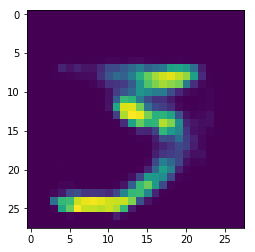

In [128]:
sample = Variable(torch.randn(64, ZDIMS))
if CUDA:
    sample = sample.cuda()

print(sample.shape)
print(sample[0])
print(sample[1])

sample = model.decode(sample).cpu()

img_data = sample.data.view(64, 1, 28, 28).numpy()

plt.imshow(img_data[0][0])
plt.imshow(img_data[1][0])